In [1]:
import os
from pysmiles import read_smiles
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch_geometric
import torch
from torch import nn
from torch_geometric.data import Dataset, DataLoader
from torchvision import models
import deepchem as dc

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.7.1+cu110
Cuda available: True
Torch geometric version: 1.7.2


# Dataset

In [2]:
class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        #self.data = self.data.iloc[29628:]
        #print(self.data.iloc[-1])
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            f = featurizer.featurize(mol["SMILES"])
            data = f[0].to_pyg_graph()
            data.smiles = mol["SMILES"]
            if not self.test:
                data.y = self._get_label(mol["target"])
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
            

    def _get_label(self, label):
        if not self.test:
            label = np.asarray([label])
            return torch.tensor(label, dtype=torch.float32)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

# Hyperparameters

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 200
#num_layers = 1
#dropout_rate = 0.1
embedding_size = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = "./models/sage/best_model.pt"

In [15]:
train_dataset = MoleculeDataset(root="../data/", filename="new_train.csv")
train_dataset  = train_dataset.shuffle()

In [16]:
int(len(train_dataset)*0.8)

24275

In [17]:
train_dataset.num_features

30

In [18]:
train_dataloader = DataLoader(train_dataset[:24275], batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
val_dataloader = DataLoader(train_dataset[24275:], batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [19]:
sample_batch = next(iter(train_dataloader))
sample_batch

Batch(batch=[1530], edge_attr=[3272, 11], edge_index=[2, 3272], ptr=[65], smiles=[64], x=[1530, 30], y=[64])

# Model

In [20]:
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool
from torch.nn import Sequential, Linear, ReLU
from torch.nn import BatchNorm1d
import torch.nn.functional as F


class GIN(nn.Module):

    def __init__(self, dim_features, dim_target, config):
        super(GIN, self).__init__()

        self.config = config
        self.dropout = config['dropout']
        self.embeddings_dim = [config['hidden_units'][0]] + config['hidden_units']
        self.no_layers = len(self.embeddings_dim)
        self.first_h = []
        self.nns = []
        self.convs = []
        self.linears = []

        train_eps = config['train_eps']
        if config['aggregation'] == 'sum':
            self.pooling = global_add_pool
        elif config['aggregation'] == 'mean':
            self.pooling = global_mean_pool

        for layer, out_emb_dim in enumerate(self.embeddings_dim):

            if layer == 0:
                self.first_h = Sequential(Linear(dim_features, out_emb_dim), BatchNorm1d(out_emb_dim), ReLU(),
                                    Linear(out_emb_dim, out_emb_dim), BatchNorm1d(out_emb_dim), ReLU())
                self.linears.append(Linear(out_emb_dim, dim_target))
            else:
                input_emb_dim = self.embeddings_dim[layer-1]
                self.nns.append(Sequential(Linear(input_emb_dim, out_emb_dim), BatchNorm1d(out_emb_dim), ReLU(),
                                      Linear(out_emb_dim, out_emb_dim), BatchNorm1d(out_emb_dim), ReLU()))
                self.convs.append(GINConv(self.nns[-1], train_eps=train_eps))  # Eq. 4.2

                self.linears.append(Linear(out_emb_dim, dim_target))

        self.nns = torch.nn.ModuleList(self.nns)
        self.convs = torch.nn.ModuleList(self.convs)
        self.linears = torch.nn.ModuleList(self.linears)  # has got one more for initial input

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        out = 0

        for layer in range(self.no_layers):
            if layer == 0:
                x = self.first_h(x)
                out += F.dropout(self.pooling(self.linears[layer](x), batch), p=self.dropout)
            else:
                # Layer l ("convolution" layer)
                x = self.convs[layer-1](x, edge_index)
                out += F.dropout(self.linears[layer](self.pooling(x, batch)), p=self.dropout, training=self.training)

        return out

In [21]:
dim_features = train_dataset.num_features
dim_target = 1
config = {'num_layers': 3, 'hidden_units': [128, 128], 'dim_embedding': 128, 'aggregation':'sum',  'train_eps':True, 'dropout':0.1}
model = GIN(dim_features, dim_target, config)
model = model.to(device)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model

Number of parameters:  88453


GIN(
  (first_h): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (nns): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_f

# Train

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [23]:
def train_step(batch_item, epoch, batch, training):
    #x = batch_item['x'].float()
    #edge_index = batch_item['edge_index']
    #batch = batch_item['batch']
    label = batch_item['y']

    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(batch_item)
            #print(output.shape)
            #print(label.shape)
            loss = criterion(output.view(-1), label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(batch_item)
            #print(output.shape)
            #print(label.shape)            
            loss = criterion(output.view(-1), label)
            
        return loss

In [24]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_item.to(device)
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_item.to(device)
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model.state_dict(), save_path)

380it [00:16, 23.21it/s, Epoch=1, Loss=0.509942, Total Loss=1.451707]
95it [00:01, 47.88it/s, Epoch=1, Val Loss=0.770956, Total Val Loss=0.646917]
380it [00:15, 24.92it/s, Epoch=2, Loss=0.550212, Total Loss=0.608966]
95it [00:01, 54.85it/s, Epoch=2, Val Loss=0.392460, Total Val Loss=0.435284]
380it [00:10, 37.59it/s, Epoch=3, Loss=0.499705, Total Loss=0.516321]
95it [00:01, 54.52it/s, Epoch=3, Val Loss=0.468405, Total Val Loss=0.448573]
380it [00:10, 36.65it/s, Epoch=4, Loss=0.629567, Total Loss=0.483925]
95it [00:01, 54.84it/s, Epoch=4, Val Loss=0.412007, Total Val Loss=0.399228]
380it [00:11, 34.11it/s, Epoch=5, Loss=0.745159, Total Loss=0.453452]
95it [00:01, 50.24it/s, Epoch=5, Val Loss=0.564879, Total Val Loss=0.555850]
380it [00:11, 34.29it/s, Epoch=6, Loss=0.364314, Total Loss=0.438791]
95it [00:01, 58.74it/s, Epoch=6, Val Loss=0.402028, Total Val Loss=0.372193]
380it [00:10, 36.33it/s, Epoch=7, Loss=0.334053, Total Loss=0.424650]
95it [00:01, 53.46it/s, Epoch=7, Val Loss=0.3956

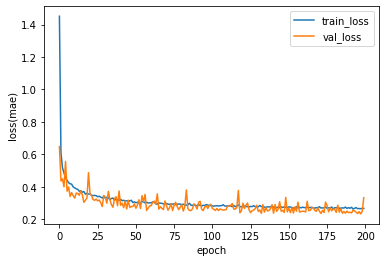

In [25]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

# Load

In [26]:
loaded_model = GIN(dim_features, dim_target, config)
loaded_model.load_state_dict(torch.load(save_path))
loaded_model = loaded_model.to(device)
#model.eval()

In [27]:
for param in loaded_model.parameters():
    print(param)
    break

Parameter containing:
tensor([[-0.1434, -0.0657, -0.0637,  ..., -0.0533,  0.0334,  0.0315],
        [ 0.1530,  0.0866,  0.0727,  ...,  0.0391,  0.0332, -0.0374],
        [-0.0318,  0.0354,  0.0041,  ..., -0.0492,  0.1438,  0.0889],
        ...,
        [-0.0815, -0.1320,  0.0704,  ...,  0.0040, -0.0205, -0.1411],
        [-0.0291, -0.0246,  0.1139,  ...,  0.0358,  0.0195,  0.0212],
        [-0.0148,  0.1083,  0.2036,  ...,  0.0496,  0.1440,  0.1559]],
       device='cuda:0', requires_grad=True)


# Test

In [28]:
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [29]:
test

,uid,SMILES
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...
...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...
598,test_598,CC1(C)c2ccccc2N(c2ccc(-c3cc(-c4ccc(N5c6ccccc6C...
599,test_599,Cc1nc(-c2ccc(N3c4ccccc4C(C)(C)c4ccccc43)cc2)cc...
600,test_600,c1ccc2c(c1)Oc1ccccc1N2c1ccc(-c2nc3ccccc3s2)cc1


In [30]:
test_dataset = MoleculeDataset(root="../data/", filename="test.csv", test=True)

In [31]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test_dataloader

In [32]:
def predict(dataset):
    loaded_model.eval()
    result = []
    for batch_item in dataset:
        batch_item.to(device)
        with torch.no_grad():
            output = loaded_model(batch_item)
        output = output[:, 0]
        output = output.cpu().numpy()
        result.extend(output)
        
    return result

In [33]:
pred = predict(test_dataloader)
submission['ST1_GAP(eV)'] = pred
submission

,uid,ST1_GAP(eV)
0,test_0,0.621473
1,test_1,0.889131
2,test_2,1.150220
3,test_3,0.706653
4,test_4,1.113952
...,...,...
597,test_597,0.149228
598,test_598,0.009230
599,test_599,-0.044352
600,test_600,0.610955


In [ ]:
submission.info()

In [ ]:
submission.to_csv('dacon_baseline.csv', index=False)

In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    'dacon_baseline.csv', 
    '59375e1f3b2f6e39215d683eaee1a165fb30ef348d1da88be153f64c17dfe759', 
    '235789', 
    'melona', 
    'sage_1'
)